In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import atmosentry
from atmosentry.meteoroid import Meteoroid

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
def gen_impactor(theta0=45*np.pi/180, R0=250):

    # impactor's heat of ablation, bulk density
    eta_imp = 2.5e6 # J/kg
    sigma_imp=1e4
    rho_imp = 0.6e3

    V0 = 20e3 # top-of-atmosphere impact velocity

    M0 = rho_imp * (4 * np.pi / 3) * (R0 ** 3) # initial mass

    impactor = Meteoroid(x=0,
                        y=0,
                        z=100e3,
                        vx=-V0 * np.cos(theta0),
                        vy=0,
                        vz=-V0 * np.sin(theta0),
                        radius=R0,
                        mass=M0,
                        sigma=sigma_imp,
                        rho=rho_imp,
                        eta=eta_imp)
    
    return impactor

In [3]:
def calc_combined_fragment_deposition(sim):
    """
    Docstring: need to combine contribution from contributions at constant altitude... (rewrite)
    """
    
    altitudes = np.linspace(0, 100e3, 10000)
    cumulative_energy_deposition = np.zeros_like(altitudes)
    cumulative_mass_deposition = np.zeros_like(altitudes)

    for j, h in enumerate(altitudes):
        cumulative_dE = 0.0
        cumulative_dM = 0.0

        cumulative_dE += np.sum(sim.impactor.state.dEkin[sim.impactor.state.z >= h])
        cumulative_dM += np.sum(sim.impactor.state.dM[sim.impactor.state.z >= h])

        for fragment in sim.fragments:
            cumulative_dE += np.sum(fragment.state.dEkin[fragment.state.z >= h])
            cumulative_dM += np.sum(fragment.state.dM[fragment.state.z >= h])
        
        cumulative_energy_deposition[j] = cumulative_dE
        cumulative_mass_deposition[j] = cumulative_dM
    
    return altitudes, cumulative_energy_deposition, cumulative_mass_deposition

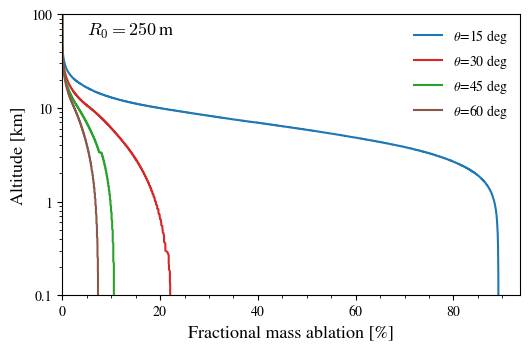

In [4]:
theta_0 = np.array([15, 30, 45, 60])
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:brown']

_ = plt.figure(figsize=(5.91, 3.65))

for counter, theta in enumerate(theta_0):


    sim = atmosentry.Simulation()

    impactor = gen_impactor(theta0=theta * np.pi / 180)
    sim.impactor = impactor

    sim.dt = 1e-2 # here you can set the maximum timestep of the simulation

    sim.integrate()

    altitudes, _, cumulative_mass_deposition = calc_combined_fragment_deposition(sim)

    plt.plot(cumulative_mass_deposition / sim.impactor.mass * 100, altitudes / 1e3, c=colors[counter], label=rf'$\theta$={theta} deg')

plt.yscale('log')

plt.xlim(0, )
plt.ylim(1e-1, 1e2)
plt.yticks([0.1, 1, 10, 100], labels=[0.1, 1, 10, 100])

plt.xlabel(r'Fractional mass ablation [%]', fontsize=13)
plt.ylabel(r'Altitude [km]', fontsize=13)

plt.minorticks_on()

plt.legend(frameon=False)

plt.text(5, 60, r'$R_0=250\,$m', fontsize=13)

plt.show()